 <h2 style="color:black; direction:rtl">ترجمه ماشین با <span style="color:#cc0066">Attention</span></h2>
 <h6 style="color:#666699" >Copyright 2018 The TensorFlow Authors.</h6>

<p style="direction:rtl;text-align:right">این نوت بوک از  یک مدل seq2seq برای ترجمه فارسی به انگلیسی با استفاده از tf.keras وtf.enable_eager_execution است.</p>

In [0]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.12.0


<h3 style="direction:rtl;text-align:right">دانلود و تهیه مجموعه داده</h3>
<h6 style="direction:rtl;text-align:right">در اینجا مراحل مورد نیاز برای تهیه داده ها را انجام می دهیم:</h6>
<ol style="direction:rtl;text-align:right">
    <li>یک علامت شروع و پایان را به هر جمله اضافه کنید.</li>
    <li>جملات را با حذف کاراکتر های خاص پاک کنید.</li>
    <li>یک  word index  ایجاد کنید و آنرا برعکس کنید (dictionaries mapping from word → id and id → word).</li>
    <li>هر جمله را به حداکثر طول برسانید.</li>
</ol>

In [0]:
# Download the file
#add file name
path_to_file = "fra.txt"

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

In [0]:

# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    
    def __init__(self, lang):
        
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()
    
    def create_index(self):
        
        for phrase in self.lang:
          self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
          self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
          self.idx2word[index] = word

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

<h3 style="direction:rtl;text-align:right">محدود کردن اندازه مجموعه داده ها برای آزمایش سریع تر (اختیاری)</h3>
<p style="direction:rtl;text-align:right">آموزش  مجموعه داده بالای 100،000 زمان بر خواهد بود. برای آموزش سریع تر می توانیم اندازه مجموعه داده ها را مثلا به 30،000 جمله محدود کنیم.البته در این حالت میزان دقت کاش میابد!</p>

In [0]:
# Try experimenting with the size of that dataset
num_examples =31000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24800, 24800, 6200, 6200)

<h3 style="direction:rtl;text-align:right">یک مجموعه داده tf.data ایجاد کنید</h3>

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

<h3 style="direction:rtl;text-align:right">مدل رمزگذار و رمزگشایی را بنویسید</h3>
<p style="direction:rtl;text-align:right">این نوت بوک مکانیزم Attention را از آموزش seq2seq پیاده سازی می کند. نمودار زیر نشان می دهد که هر کلمه ورودی یک وزن با توجه به مکانیزم attention دارد که سپس توسط رمزگذار برای پیش بینی کلمه بعدی در جمله استفاده می شود.</p>
<img src="img/dig1.png">

<p style="direction:rtl;text-align:right">ورودی از طریق یک مدل رمزگذار قرار می گیرد که به ما خروجی رمزگذار اندازه (batch_size، max_length، hidden_size) 
    و حالت پنهان رمزگذار 
    (batch_size، hidden_size) را می دهد.</p>
    
<h5 style="direction:rtl;text-align:right">در اینجا معادلات اجرا می شوند:</h5>   
<img src="img/e1.png">
<br><br>
<p style="direction:rtl;text-align:right">ما ازBahdanau attention  استفاده می کنیم. قبل از نوشتن فرم ساده، تصمیم گیری در مورد نماد انجام می شود:</p>

<ul style="direction:rtl;text-align:right">
    <li>FC = Fully connected (dense) layer</li>
    <li>EO = Encoder output</li>
    <li>H = hidden state</li>
    <li>X = input to the decoder</li>
    </ul>
<br>  
<p style="direction:rtl;text-align:right">و شبه کد:</p>

<ul style="direction:rtl;text-align:right">
    <li style="direction:ltr;text-align:left">score = FC(tanh(FC(EO) + FC(H)))</li>
    <li style="direction:ltr;text-align:left">attention weights = softmax(score, axis = 1)</li>
    <span style="direction:rtl;text-align:right">Softmax به طور پیش فرض بر روی محور آخر اعمال می شود، اما در اینجا ما می خواهیم آن را در محور اول اعمال کنیم، زیرا شکل نمره (batch_size، max_length، 1) است. Max_length طول ورودی ما است. از آنجا که ما سعی می کنیم وزن را برای هر ورودی اختصاص دهیم، softmax باید بر آن محور اعمال شود.</span>
    
<li style="direction:ltr;text-align:left">context vector = sum(attention weights * EO, axis = 1).</li>
<li style="direction:ltr;text-align:left">embedding output = The input to the decoder X is passed through an embedding layer.</li>
<li style="direction:ltr;text-align:left">merged vector = concat(embedding output, context vector)</li>
<li style="direction:ltr;text-align:left">This merged vector is then given to the GRU</li>
</ul>
<br>
<p style="direction:rtl;text-align:right">شکل همه بردارها در هر مرحله در comment در کد مشخص شده است:</p>

In [0]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

<h3 style="direction:rtl;text-align:right">تعریف  optimizer و عملکرد loss function</h3>

In [0]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

<h3 style="text-align:right"rtl;>Checkpoints (Object-based saving)</h3>

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

<h3 style="direction:rtl;text-align:right">Training</h3>

<ol style="direction:rtl;text-align:right">
    <li >ورودی از طریق رمزگذار عبور می کند که خروجی رمزگذار  و hidden state اش را برمیگرداند.</li>
    <li >خروجی رمزگذار،  hidden state رمزگذار و ورودی رمزگذار (که علامت شروع است) به رمزگذار منتقل می شود.</li>
    <li >رمزگشا پیش بینی ها و  hidden state رمزگشایی را برمیگرداند.</li>
    <li >و سپس hidden state رمزگذار  به مدل منتقل می شود و پیش بینی ها برای محاسبه loss استفاده می شود.</li>
    <li >استفاده ازteacher forcing برای تصمیم گیری ورودی بعدی به رمزگشای.</li>
    <li >اما Teacher forcing تکنیکی است که کلمه مورد نظر به عنوان ورودی بعدی به رمزگشایی منتقل می شود.</li>
    <li >مرحله نهایی محاسبه گرادیان ها و اعمال آن به optimizer  و backpropagate است.</li>
</ol>    

In [0]:
EPOCHS = 2

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.0012
Epoch 1 Batch 100 Loss 1.0194
Epoch 1 Batch 200 Loss 0.8746
Epoch 1 Batch 300 Loss 0.9165
Epoch 1 Loss 0.9968
Time taken for 1 epoch 103.46005201339722 sec

Epoch 2 Batch 0 Loss 0.8353
Epoch 2 Batch 100 Loss 0.5950
Epoch 2 Batch 200 Loss 0.7256
Epoch 2 Batch 300 Loss 0.7323
Epoch 2 Loss 0.6700
Time taken for 1 epoch 103.70070195198059 sec



<h3 style="direction:rtl;text-align:right">Translate</h3>

<ul style="direction:rtl;text-align:right">
    
<li>تابع ارزیابی شبیه به حلقه training است، به جز اینکه از  teacher forcing استفاده نمی کنیم.ورودی به رمزگشای در هر گام زمانی، پیش بینی های قبلی خود را همراه با hidden state و خروجی رمزگذار است.</li>
<li>توقف پیش بینی زمانی که مدل end token  را پیش بینی میکند</li>
<li>و وزن attention را برای هر گام زمانی ذخیره کنید.</li>
<li></li>
</ul>

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt-1'

<h3 style="text=align:right;direction:rtl">Restore the latest checkpoint and test</h3>

Input: <start> bonjour <end>
Predicted translation: shut up here . <end> 


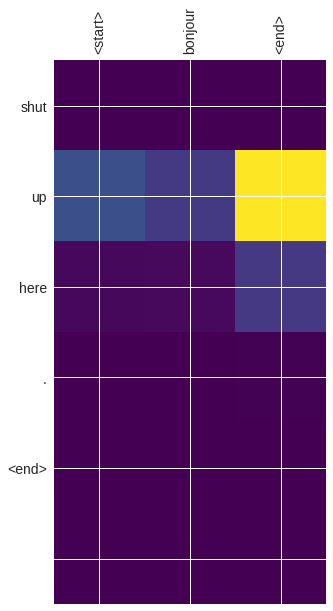

In [0]:
translate(u'', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)